In [50]:
!pip install groq faiss-cpu transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 36.9 MB/s eta 0:00:00


In [2]:
import os
from getpass import getpass
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
import pickle
import numpy as np

GROQ_API_KEY··········


In [ ]:
os.environ['GROQ_API_KEY'] = getpass("GROQ_API_KEY")

# Classification

## Problem Definition: Insurance Support Ticket Classifier

*Note: The problem definition, data, and labels used in this example were synthetically generated by Claude 3 Opus*

In the insurance industry, customer support plays a crucial role in ensuring client satisfaction and retention. Insurance companies receive a high volume of support tickets daily, covering a wide range of topics such as billing, policy administration, claims assistance, and more. Manually categorizing these tickets can be time-consuming and inefficient, leading to longer response times and potentially impacting customer experience.

#### Category Definitions

1. Policy Administration
- Requests for policy changes, updates, or cancellations
- Questions about policy renewals and reinstatements
- Inquiries about adding or removing coverage options

2. Claims Assistance
- Questions about the claims process and filing procedures
- Requests for help with submitting claim documentation
- Inquiries about claim status and payout timelines

3. Billing Disputes
- Complaints about unexpected or incorrect charges
- Requests for refunds or premium adjustments
- Inquiries about late fees or collection notices


4. General Inquiries
- Questions about company contact information or hours of operation
- Requests for general information about products or services
- Inquiries that don't fit neatly into other categories


#### Labeled Data

We will use the following datasets:
- `./data/test.tsv`
- `./data/train/tsv`

In [43]:
import pandas as pd

data = {
    'train': [],
    'test': [],
    'test_2': []
}

# Helper function to convert a DataFrame to a list of dictionaries
def dataframe_to_dict_list(df):
    return df.apply(lambda x: {'text': x['text'], 'label': x['label']}, axis=1).tolist()


# Read the TSV file into a DataFrame
test_df = pd.read_csv("test.tsv", sep='\t')
data['test'] = dataframe_to_dict_list(test_df)

train_df = pd.read_csv("train.tsv", sep='\t')
data['train'] = dataframe_to_dict_list(train_df)

In [44]:
# Understand the labels in the dataset
labels = list(set(train_df['label'].unique()))

# Print the first training example and the number of training examples
print(data['train'][0], len(data['train']))

{'text': "There's an unfamiliar charge from your company on my credit card statement that doesn't match my usual premium payment. Could you please investigate this for me?", 'label': 'Billing Disputes'} 36


In [45]:
# Create the test set
X_test = [example['text'] for example in data['test']]
y_test = [example['label'] for example in data['test']]

# Print the length of the test set
print(len(X_test), len(y_test))

24 24


### Evaluating each classification model

The `evaluate` function takes the following parameters:
- `X`: The input features.
- `y`: The true labels.
- `classifier`: The classifier function to be evaluated.

The `plot_confusion_matrix` function takes the following parameters:
- `cm`: The confusion matrix.
- `labels`: The labels for the classes.

By using this evaluation code, you can assess the performance of your classifier and visualize the confusion matrix to gain insights into the model's predictions.

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import concurrent.futures
import numpy as np

#you can increase this number to speed up evaluation, but keep in mind that you may need a higher API rate limit
#see https://docs.anthropic.com/en/api/rate-limits#rate-limits for more details

def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def evaluate(X, y, classifier):
    # Initialize lists to store the predicted and true labels
    y_true = []
    y_pred = []

    for i in range(len(X)):
        x = X[i]
        predicted_label = classifier(x)
        y_pred.append(predicted_label)
        y_true.append(y[i])

    # Normalize y_true and y_pred
    y_true = [label.strip() for label in y_true]
    y_pred = [label.strip() for label in y_pred]

    # Calculate the classification metrics
    report = classification_report(y_true, y_pred, labels=labels, zero_division=1)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(report)
    plot_confusion_matrix(cm, labels)

### Simple Classification Test

Now lets construct a simple classifier using Claude.

First we will encode the categories in XML format. This will make it easier for Claude to interpret the information. Encoding information in XML is a general prompting strategy, for more information [see here](https://docs.anthropic.com/claude/docs/use-xml-tags)

In [31]:
import textwrap

categories = textwrap.dedent("""
<category>
    <label>Policy Administration</label>
    <content> Requests for policy changes, updates, or cancellations Questions about policy renewals and reinstatements Inquiries about adding or removing coverage options
    </content>
</category>
<category>
    <label>Claims Assistance</label>
    <content> Questions about the claims process and filing procedures Requests for help with submitting claim documentation Inquiries about claim status and payout timelines
    </content>
</category>
<category>
    <label>Billing Disputes</label>
    <content> Complaints about unexpected or incorrect charges Requests for refunds or premium adjustments Inquiries about late fees or collection notices
    </content>
</category>
<category>
    <label>General Inquiries</label>
    <content> Questions about company contact information or hours of operation Requests for general information about products or services Inquiries that don't fit neatly into other categories
    </content>
</category>""")

Next we will construct a classify function that does the following things:
- Defines the prompt template
- Inputs the variables in out prompt template
- Extracts a normalized response

Notice that we leverage the `role: assistant` message and the `stop_sequences` parameter to repeatably extract the results.

In [13]:
from groq import Groq

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [32]:
# Function to call OpenAI
def get_response(prompt):

    completion = client.chat.completions.create(
      model="llama-3.3-70b-versatile",
      messages=[
          {
              "role": "user",
              "content": prompt,
          },
      ],
      max_tokens=4096,
      temperature=0.0,
    )

    return completion.choices[0].message.content

In [39]:
import re

def simple_classify(X):
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X)
    response = get_response(prompt)

    match = re.search(r"<category>(.*?)</category>", response)
    category = match.group(1) if match else None

    return category


In [40]:
X_test[0:1][0]

"There's a mysterious charge from your insurance company on my recent credit card statement that doesn't coincide with my regular premium payment. Can you investigate the nature of this charge and clarify why it was applied to my account?"

In [41]:
simple_classify(X_test[0:1][0])

'Billing Disputes'

Evaluating the simple classification method on the test set...
                       precision    recall  f1-score   support

    Billing Inquiries       1.00      1.00      1.00         0
    Claims Assistance       1.00      1.00      1.00         6
Policy Administration       0.75      1.00      0.86         6
    General Inquiries       1.00      0.67      0.80         6
     Billing Disputes       1.00      1.00      1.00         6

             accuracy                           0.92        24
            macro avg       0.95      0.93      0.93        24
         weighted avg       0.94      0.92      0.91        24



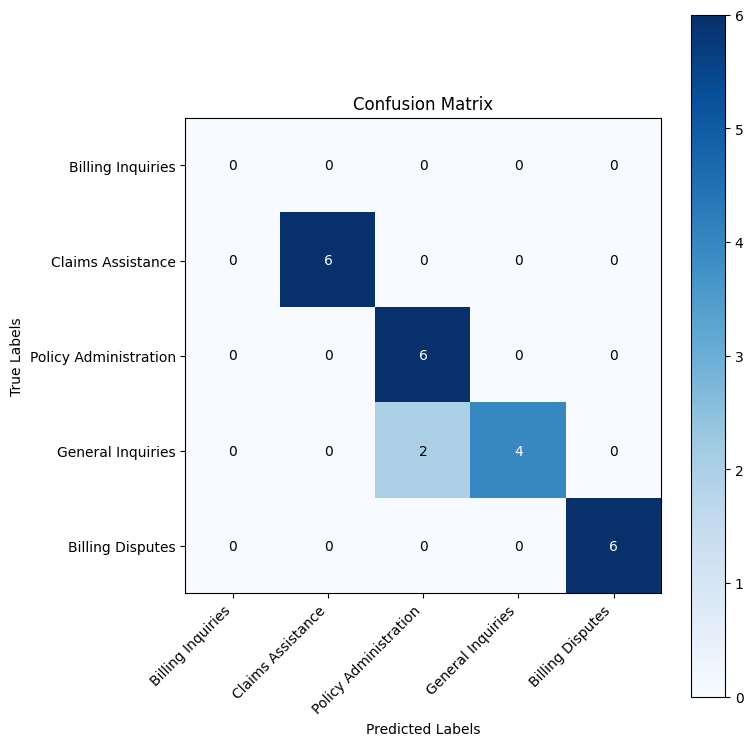

In [46]:
print("Evaluating the simple classification method on the test set...")
evaluate(X_test, y_test, simple_classify)

These results are better than random but can surely be improved! Lets add RAG with K-shot examples to the prompt.

To do this we will need to leverage a VectorDB, this will allow us to match a given query with similar examples from the training data. These examples will hopefully help increase the accuracy of our classifier

In [52]:
import os
import json
import pickle
import faiss
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel


class VectorDB:
    def __init__(self):
        self.model_name = "BAAI/bge-small-en-v1.5"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.eval()

        self.index = None
        self.metadata = []
        self.query_cache = {}
        self.index_path = "faiss_index.index"
        self.meta_path = "metadata.pkl"
        self.query_cache_path = "query_cache.json"

    def _embed(self, texts):
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0]  # CLS token
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        return embeddings.cpu().numpy()

    def load_data(self, data):
        if os.path.exists(self.index_path) and os.path.exists(self.meta_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        print("Embedding and creating new FAISS index.")
        texts = [item["text"] for item in data]
        batch_size = 128
        all_embeddings = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            embeddings = self._embed(batch_texts)
            all_embeddings.append(embeddings)

        embeddings_np = np.vstack(all_embeddings).astype('float32')
        self.index = faiss.IndexFlatL2(embeddings_np.shape[1])
        self.index.add(embeddings_np)
        self.metadata = data

        self.save_db()
        print("Vector database loaded and saved.")

    def search(self, query, k=5, similarity_threshold=0.75):
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self._embed([query])[0]
            self.query_cache[query] = query_embedding.tolist()  # Save as list for JSON

        if self.index is None:
            raise ValueError("No FAISS index found. Please load data first.")

        query_embedding_np = np.array([query_embedding], dtype='float32')
        distances, indices = self.index.search(query_embedding_np, k * 2)  # search more to apply threshold

        top_examples = []
        for i, idx in enumerate(indices[0]):
            similarity = 1 - distances[0][i] / 2  # Convert L2 distance to cosine similarity approximation
            if similarity >= similarity_threshold:
                top_examples.append({
                    "metadata": self.metadata[idx],
                    "similarity": float(similarity)
                })
            if len(top_examples) >= k:
                break

        self.save_db()
        return top_examples

    def save_db(self):
        os.makedirs("./data", exist_ok=True)
        faiss.write_index(self.index, self.index_path)
        with open(self.meta_path, "wb") as f:
            pickle.dump(self.metadata, f)
        with open(self.query_cache_path, "w") as f:
            json.dump(self.query_cache, f)

    def load_db(self):
        self.index = faiss.read_index(self.index_path)
        with open(self.meta_path, "rb") as f:
            self.metadata = pickle.load(f)
        if os.path.exists(self.query_cache_path):
            with open(self.query_cache_path, "r") as f:
                self.query_cache = json.load(f)


We can define the vector db and load our training data.

VoyageAI has a rate limit of 3RPM for accounts without an associated credit card. For ease of demonstration we will leverage a cache.

In [53]:
vectordb = VectorDB()
vectordb.load_data(data["train"])

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Embedding and creating new FAISS index.
Vector database loaded and saved.


### RAG Classification Prompt

In this prompt we are leveraging Retrieval Augmented Generation (RAG) to insert examples from the training data that have semantically similar queries.

In [54]:
def rag_classify(X):
    rag = vectordb.search(X,5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    response = get_response(prompt)

    match = re.search(r"<category>(.*?)</category>", response)
    category = match.group(1) if match else None

    return category

Evaluating the RAG method on the test set...
                       precision    recall  f1-score   support

    Billing Inquiries       1.00      1.00      1.00         0
    Claims Assistance       1.00      1.00      1.00         6
Policy Administration       1.00      1.00      1.00         6
    General Inquiries       1.00      1.00      1.00         6
     Billing Disputes       1.00      1.00      1.00         6

             accuracy                           1.00        24
            macro avg       1.00      1.00      1.00        24
         weighted avg       1.00      1.00      1.00        24



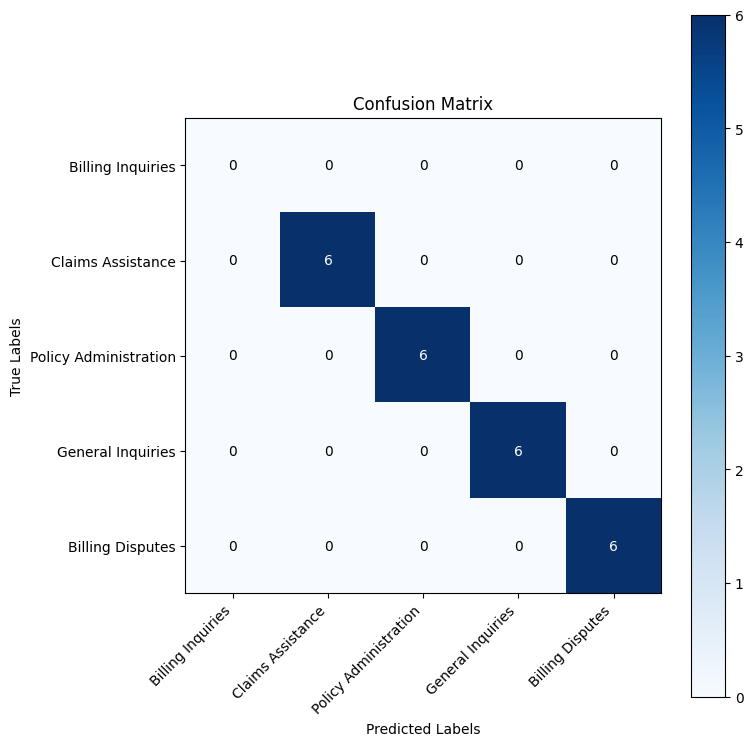

In [55]:
print("Evaluating the RAG method on the test set...")
evaluate(X_test, y_test, rag_classify)